In [2]:
%autoreload 2

In [3]:
from collections import defaultdict
import copy
import os
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS


In [4]:
fitness_df = utils.load_fitness_data()
print(fitness_df.columns)
fitness_df.head()

Index(['Index', 'src_file', 'game_name', 'domain_name', 'variables_defined',
       'all_preferences_used', 'setup_objects_used', 'no_adjacent_once',
       'starts_and_ends_once', 'variable_not_repeated', 'no_nested_logicals',
       'pref_forall_correct', 'real', 'original_game_name'],
      dtype='object')


,Index,src_file,game_name,domain_name,variables_defined,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.00,1.0,0.5,1.0,1.0,1.0,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,0.00,0.0,0.0,1.0,0.0,0.0,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,0.25,1.0,1.0,1.0,1.0,1.0,True,614dec67f6eb129c3a77defd-6


In [5]:
syntethic_fitness_df = fitness_df[fitness_df.src_file.isin(('ast-mle-samples.pddl', 'ast-mle-regrowth-samples.pddl'))].reset_index(drop=True)
syntethic_fitness_df.loc[syntethic_fitness_df.src_file == 'ast-mle-samples.pddl', 'original_game_name'] = syntethic_fitness_df.loc[syntethic_fitness_df.src_file == 'ast-mle-samples.pddl', 'game_name']

In [6]:
syntethic_fitness_df.head()

,Index,src_file,game_name,domain_name,variables_defined,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,real,original_game_name
0,98,ast-mle-samples.pddl,game-id-0,medium-objects-room-v1,1.0,0.333333,0.000000,0.000000,0.500000,0.800000,1.0,0.500000,False,game-id-0
1,99,ast-mle-samples.pddl,game-id-1,few-objects-room-v1,1.0,0.000000,0.000000,0.000000,0.000000,0.833333,1.0,0.000000,False,game-id-1
2,100,ast-mle-samples.pddl,game-id-2,few-objects-room-v1,1.0,1.000000,0.500000,0.000000,0.000000,0.800000,1.0,0.000000,False,game-id-2
3,101,ast-mle-samples.pddl,game-id-3,many-objects-room-v1,1.0,1.000000,0.428571,0.333333,0.666667,0.727273,1.0,0.333333,False,game-id-3
4,102,ast-mle-samples.pddl,game-id-4,medium-objects-room-v1,0.0,1.000000,0.000000,0.000000,1.000000,0.600000,1.0,0.000000,False,game-id-4


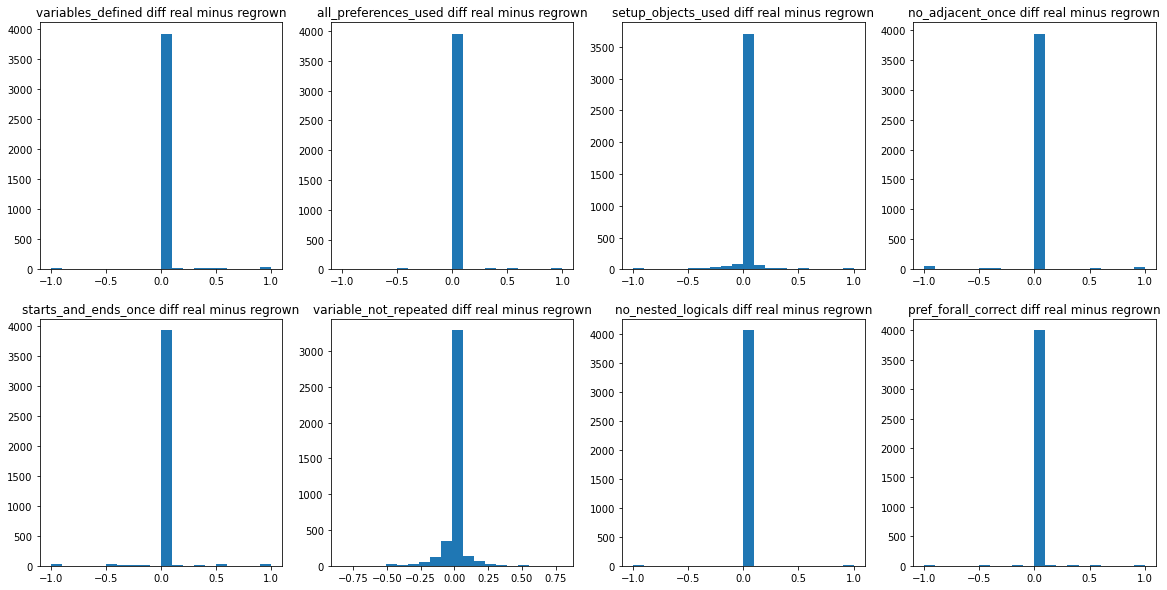

In 58.33% of the games, the regrown game was identical to the original game.


In [7]:
fake_games = syntethic_fitness_df[syntethic_fitness_df.src_file == 'ast-mle-regrowth-samples.pddl'].reset_index()
broadcasted_original = syntethic_fitness_df.loc[[syntethic_fitness_df.index[(syntethic_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
index = 0
for column in original_regrown_diffs.columns:
    if column in ('index', 'Index', 'real'):
        continue

    ax = axes[index // 4][index % 4]
    ax.hist(original_regrown_diffs[column], bins=20)
    ax.set_title(f'{column} diff real minus regrown')
    index += 1

plt.show()
unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')